# Visualisation of I<sub>p</sub> and Electron photoemission spectra obtained by *cntr* code

### Warning: material-specific code, use only for La<sub>2</sub>CuO<sub>4</sub>, implicit energy renormalization 0.43, based on compound bandwidth and lattice constant 3.78 A is used. Only *x* field projection is read from the current file, i.e. the value of current is multiplied by sqrt(2) for the [110] polarization


#### File name: **I_p.py** 
#### Input:
- *DMFT* calculation parameters are read from *cntr* input file
  - Single *cntr* input file should exist in the working directory
  - The name of the *cntr* input file should start with "**inp**"
- Photoemission spectrum file **Spectr_PES.out**, output of ... script 
- Total Energy versus time **E_tot.out**, output of *cntr* code
  - Energy renormalization is **0.43** (hard-coded, material-specific for La<sub>2</sub>CuO<sub>4</sub> due to material bandwidth)
- Electric current **Pulse_xy.dat**, output of *cntr* code\
  - Only *x* field projection is read from the current file, i.e. the value of current is multiplied by sqrt(2) for the [110] polarization
  
#### Output:
The **png** file with name Ip40LCOom**W.WWW**u**U.U**emax**EeEE**.png, where **W.WWW** is pulse frequency, **U.U** is Hubbard U (in eV), **EeEE** is electric field amplitude (in V/m). 

The upper panel shows derivative of total energy w.r.t. time (blue), it's approximation by fitting I<sub>p</sub> (green), the points shows two first large maxima (greater than 40% of the global maximum) of the derivative.

The middle panel shows electric field profile, the points shows times of the total energy derivative maxima.

The lower panel shows electron photoemission spectrum

### Code

#### Loading libraries:

In [1]:
####%matplotlib inline
################ Libraries ###############################
import numpy as np
from fractions import Fraction
import matplotlib.pyplot as plt
import matplotlib.colors as collors
import matplotlib.cm as cmx
import scipy.signal
import sys
import glob
import re
import math

#plt.rcParams.update({'font.size': 22})

#### Arrays and parameters definition:

In [2]:
##############  defining arrays  #############
time = np.array([])
E_tot_eV = np.array([])
dE_tot_dt = np.array([])
W_dot = np.array([])
E_field = np.array([])

###################### Not used: command line input parameters  ###################
#if (len(sys.argv)!=2): sys.exit('need Energy/time renormalization parameter: how much eV is in this runs energy unit???')
#renorm=float(sys.argv[1])

#######################
#######################
#######################

#LCO-XY-Linear-polarization-specific script !!!!!!!!!!!!!!!!!!!!!!!!
renorm=0.43
#############  script for LCO, a0 is in-plane lattice constant  !!!!!!!!!!
a_0=3.78e-10 
# one E component only available in control and pulse files,
# should be read and multiplied by Efactor=sqrt(2) 
Efactor=np.sqrt(2)

#### Reading input files:

In [3]:
############# input parameters from control input file inp*   ############
inpFiles = glob.glob('./inp*')
if (len(inpFiles)!=1):
	sys.exit('Problem with input files (too few or too many)')
	
with open(inpFiles[0]) as file:
    inpp = file.read()
inpVals = re.findall(r'(\_+\w+)=(.+)', inpp)
inpDict = dict(inpVals)

### distance between consequent time points from input files in fs
spacing = float(inpDict["__h"])*0.66/renorm

### pulse central frequency in eV
omega_eV= float(inpDict["__omega"])*renorm

### Coulomb repulsion in eV
U_eV= float(inpDict["__U"])*renorm

### Maximal electric field strength of pulse envelope in V/m
EmaxVM= float(inpDict["__E"])*Efactor*omega_eV/a_0

############### reading files and converting data to the proper units  ##########################

### total energy and time:
dataEtot=np.genfromtxt('E_tot.out', skip_header=1)
time=dataEtot[:,0]*spacing	 
E_tot_eV=dataEtot[:,4]*renorm	

### Electric field as -time derivative of the vector potential
#### since Pulse_xy.dat filename is specific for [110] linear pulse polarization,
#### we take first component of vector potential and multiply it by sqrt(2):  !!!!!!!!!!!!!!!!

dataAxy=np.genfromtxt('Pulse_xy.dat', skip_header=1)
E_field=-np.gradient(dataAxy[:,1],spacing)*Efactor

##### read PES data
dataPES=np.genfromtxt('Spectr_PES.out')

#### Calculating Ip, and derivatives of total energy:

In [4]:
###########################  calculating Ip  ################
######  $I_p = \frac{1}{2}\left( \frac{-\frac{3}{2}ln\frac{{\dot W}_1}{{\dot W}_2}}{E_1^{-1}-E_2^{-1}} \right)^{2/3}$	

# get time derivative of Etot, units are eV/fs:	
dE_tot_dt=np.gradient(E_tot_eV,spacing)

# find all maxima of dE_tot/dt:
W_dot=scipy.signal.argrelextrema(dE_tot_dt,np.greater)
	
# select all maxima of W_dot=dE_tot/dt that are greater than 40% of global maximum of dE_tot/dt:
GlobalWdotMax=max(dE_tot_dt[W_dot])

BigMaxIndices=W_dot[0][np.where(dE_tot_dt[W_dot]>0.4*GlobalWdotMax)[0]]
IpCalcIndices=np.array([BigMaxIndices[0],BigMaxIndices[1]])

# take values of dE_tot/dt at the first and the second maxima, exceeding 40% of global maximum:
W_1_dot=dE_tot_dt[IpCalcIndices[0]]
W_2_dot=dE_tot_dt[IpCalcIndices[1]]

# calculating inverse values of electric field strength ABSOLUTE VALUE at the first and the second maxima
# units are (eV/a_0)^-1, where a_0 is in-plane lattice constant:
E1m1=1.0/np.abs(E_field[IpCalcIndices[0]])
E2m1=1.0/np.abs(E_field[IpCalcIndices[1]])

# calculating Ip :

OneThird=Fraction('1/3')
Ip=0.5*((((-3.0/2.0)*np.log(W_1_dot/W_2_dot))/(E1m1-E2m1))**2)**(OneThird)
#print('Ip = ',Ip)

# calculating fit of dE_tot/dt by formula
# $dE_{\rm tot}/dt\right|_{t=t_i}=\alpha e^{-\frac{2}{3}\frac{(2I_p)^{3/2}}{E(t_i)}}$,
# alpha is fitted to match dE_tot/dt value at the second significant maximum: 

alpha=dE_tot_dt[IpCalcIndices[1]]/np.exp((-2.0/3.0)*(np.sqrt((2*Ip)**3))/(np.abs(E_field[IpCalcIndices[1]])))
dEdtFitted=alpha*np.exp((-2.0/3.0)*(np.sqrt((2*Ip)**3))/(np.abs(E_field)))	



#### Making three-panel figure:

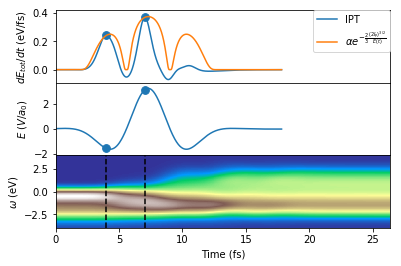

In [5]:
######################## making plots  #########################
fig, axs = plt.subplots(3, 1, sharex=True)
fig.subplots_adjust(hspace=0)

TimeZero=dataPES[0,0]*spacing

## Upper panel, derivative of total energy vs time
axs[0].plot(time-TimeZero,dE_tot_dt, label="IPT") 
axs[0].scatter(time[IpCalcIndices]-TimeZero, dE_tot_dt[IpCalcIndices], s=60)
axs[0].plot(time-TimeZero,dEdtFitted, label=r'$\alpha e^{-\frac{2}{3}\frac{(2I_p)^{3/2}}{E(t)}}$')
axs[0].set_ylabel(r'$dE_{tot}/dt$ (eV/fs)')
plt.setp(axs[0].get_yticklabels()[0], visible=False)
axs[0].legend(loc='upper right', borderaxespad=0.)

## Middle panel: electric field profile
axs[1].plot(time-TimeZero,E_field)
axs[1].scatter(time[IpCalcIndices]-TimeZero, E_field[IpCalcIndices], s=60)
axs[1].set_ylabel(r'$E$ $(V/a_0)$')
plt.setp(axs[1].get_yticklabels()[0], visible=False)    
plt.setp(axs[1].get_yticklabels()[-1], visible=False)


## Lower panel: photoelectron emission: energy vs. time:
cm = plt.get_cmap("terrain")
cNorm = collors.Normalize(vmin=min(dataPES[:,2]), vmax=max(dataPES[:,2]))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
axs[2].scatter(dataPES[:,0]*spacing-TimeZero,dataPES[:,1]*renorm, s=2, c=scalarMap.to_rgba(dataPES[:,2]), marker="s", linewidth=0)  
axs[2].set_xlabel('Time (fs)')
axs[2].set_ylabel(r'$\omega$ (eV)')
axs[2].set_xlim(0,dataPES[-1,0]*spacing-TimeZero)
omMaxPlot=math.trunc(dataPES[-1,1]*renorm)-0.001
axs[2].set_ylim(-omMaxPlot,omMaxPlot)
for time12 in time[IpCalcIndices]:
    plt.axvline(x=time12-TimeZero, color='k', linestyle='--')
